# Demo de modelos de Reservoir Computing (RC) para clasificar (atributo clase discreto) o estimar (atributo clase continuo) usando Serie Temporal

Librería: https://github.com/PlasmaControl/PyRCN

Documentación:  

https://www.sciencedirect.com/science/article/abs/pii/S0952197622001713

https://pyrcn.readthedocs.io/en/latest/?badge=latest

Otros:

https://github.com/reservoirpy/awesome-reservoir-computing


In [1]:
#@title Instalar PyRCN y actualiza SKLearn
!pip3 install -U scikit-learn
!pip3 install -U pyrcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 4.5 MB/s eta 0:00:00


In [2]:
#@title Librerías a usar
import pyrcn

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import csv

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [3]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [4]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'CLIMA_nuevo.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Yori, Xori, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Yori = np.array(df[attClase])
  Xori = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", Xori.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Yori.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
Xori = None
Yori = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  CLIMA_nuevo.csv  cargado

> Cabecera: 
   fecha_dia  fecha_mes  temp_prom  temp_min  tem_max  viento_dir  viento_vel  \
0          1          1       24.8      20.6     34.6          15        14.8   
1          2          1       26.4      16.7     35.0         354        10.6   
2          3          1       29.2      21.0     37.2          75        11.2   
3          4          1       28.1      20.7     37.6         231        15.6   
4          5          1       20.6      10.5     31.1         130        16.1   

   presion  precipitacion  
0   1003.6            0.0  
1   1004.6            0.0  
2   1006.7            0.0  
3   1005.9            0.0  
4   1015.4            0.0  

> Características: 
        fecha_dia   fecha_mes   temp_prom    temp_min     tem_max  viento_dir  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean    15.720548    6.526027   17.733836   11.902466   24.531233  151.952055   
std      8.802278    3.4

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo precipitacion como de entrada dado que es clase.

> Atributos entrada:  ['fecha_dia', 'fecha_mes', 'temp_prom', 'temp_min', 'tem_max', 'viento_dir', 'viento_vel', 'presion']
	 X:  (730, 8)

> Atributo clase:  precipitacion
	 Y:  (730,)

Eliminando atributo temp_prom como de entrada dado que es clase.

> Atributos entrada:  ['fecha_dia', 'fecha_mes', 'temp_min', 'tem_max', 'viento_dir', 'viento_vel', 'presion', 'precipitacion']
	 X:  (730, 8)

> Atributo clase:  temp_prom
	 Y:  (730,)


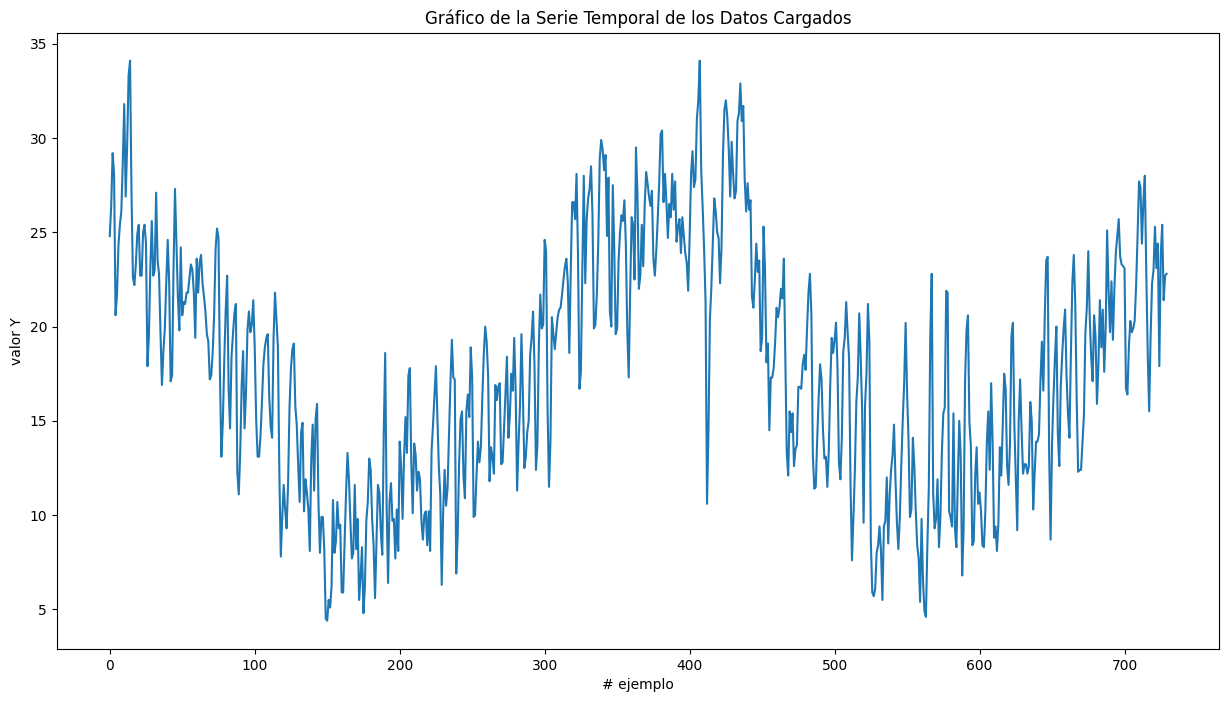

In [5]:
#@title Mostrar Gráfico de los datos cargados


# función auxiliar para graficar datos
def graficarSerieDatos(datosReal, datosModelo=None, titulo=""):
  if (datosReal is None) and (datosModelo is None):
    return
  legNames = []
  plt.figure(figsize=(15,8))
  if datosReal is not None:
    plt.plot(datosReal)
    legNames.append( "Real" )
  if datosModelo is not None:
    plt.plot(datosModelo)
    legNames.append( "Modelo" )
  if titulo != "":
    plt.title(titulo)

  plt.ylabel('valor Y')
  plt.xlabel('# ejemplo')
  if len(legNames) > 1:
    plt.legend(legNames, loc='upper left')
  plt.show()


graficarSerieDatos(datosReal=Yori,
                   titulo="Gráfico de la Serie Temporal de los Datos Cargados")

In [6]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "MinMax Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  Xori = scaler.fit_transform(Xori)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

In [7]:
#@title Generar secuencia de datos como Serie

cantidad_intervalos_secuencia = 3 #@param {type:"integer"}

usar_atributos_secuencia = "Solo atributo a Estimar" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix]
      seq_y = datosY[end_ix]
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

# define nombre atributos a considerar
def definirNombreAtributos(cantidad_intervalos_secuencia, inclX, inclY):
  auxAttList = []
  if not(inclY or inclX):
    inclY = True
  for i in range(cantidad_intervalos_secuencia):
    if cantidad_intervalos_secuencia > 1:
      auxiID = "#"+str(i+1)
    else:
      auxiID = ""
    if inclX:
      for at in list(combo_att_entrada.value):
        if str(at) != str(combo_att_clase.value):
          auxAttList.append( str(at) + auxiID )
    if inclY:
      auxAttList.append( str(combo_att_clase.value) + auxiID)
  return auxAttList

# procesa
print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
auxAttList = []
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar":
  atrSeq = "Y"
  cant_atributos_entrada = 1
  auxAttList = definirNombreAtributos(cantidad_intervalos_secuencia, inclX=False, inclY=True)
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
  auxAttList = definirNombreAtributos(cantidad_intervalos_secuencia, inclX=True, inclY=False)
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
  auxAttList = definirNombreAtributos(cantidad_intervalos_secuencia, inclX=True, inclY=True)

X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)



print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)
print(">Atributos de entrada: ", auxAttList)


> Antes de generar serie: 
[1.0000e+00 1.0000e+00 2.0600e+01 3.4600e+01 1.5000e+01 1.4800e+01
 1.0036e+03 0.0000e+00] 24.8
[2.0000e+00 1.0000e+00 1.6700e+01 3.5000e+01 3.5400e+02 1.0600e+01
 1.0046e+03 0.0000e+00] 26.4
[3.0000e+00 1.0000e+00 2.1000e+01 3.7200e+01 7.5000e+01 1.1200e+01
 1.0067e+03 0.0000e+00] 29.2
[4.0000e+00 1.0000e+00 2.0700e+01 3.7600e+01 2.3100e+02 1.5600e+01
 1.0059e+03 0.0000e+00] 28.1
[5.0000e+00 1.0000e+00 1.0500e+01 3.1100e+01 1.3000e+02 1.6100e+01
 1.0154e+03 0.0000e+00] 20.6


> Generando series con  3  intervalos 

> Después de generar serie: 
[24.8 26.4 29.2] 28.1
[26.4 29.2 28.1] 20.6
[29.2 28.1 20.6] 21.7
[28.1 20.6 21.7] 24.3
[20.6 21.7 24.3] 25.4


>Atributos de entrada:  ['temp_prom#1', 'temp_prom#2', 'temp_prom#3']


In [8]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (545, 3, 1)
 - y_train (cant):  545

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (182, 3, 1)
 - y_test (cant):  182


# Modelo:

In [9]:
#@title Establecer modelo

import pyrcn.echo_state_network as esn
import pyrcn.extreme_learning_machine as elm

from pyrcn.base.blocks import BatchIntrinsicPlasticity
from sklearn.pipeline import Pipeline, FeatureUnion
from pyrcn.base.blocks import InputToNode, NodeToNode

from pyrcn.linear_model import IncrementalRegression
from sklearn.linear_model import Ridge as skRidge
from sklearn.linear_model import LinearRegression as skLinearRegression

from joblib import dump, load


#@markdown ### Parámetros Generales:
tipoRCmodel = "Extreme Learning Machine" #@param ["Echo State Network", "Extreme Learning Machine"]
tipoRegressor = "Incremental Regression" #@param ["Incremental Regression", "skLinearRegression", "skRidge"]
# define tipo regressor
tipoRegressorAux = str(tipoRegressor).lower()
if (tipoRegressorAux =="sklinearregression"):
  regressor = skLinearRegression()
elif (tipoRegressorAux =="skridge"):
  regressor = skRidge()
elif (tipoRegressorAux =="incremental regression"):
  regressor = IncrementalRegression()
else:
  regressor = None


#@markdown ### Parámetros de Capas:
input_hidden_layer_size = 500 #@param {type:"integer"}
input_activation = "identity" #@param ["identity", "tanh", "logistic", "relu"]
reservoir_activation = "tanh" #@param ["identity", "tanh", "logistic", "relu"]
recurrent_weights_per_node = 10 #@param {type:"integer"}

# determina inputs
inputPipeLineList = []
cantInput = 0
for at in auxAttList:
  cantInput += 1
  at = str(at)
  pl = Pipeline([('i_'+at,
                  InputToNode(hidden_layer_size=input_hidden_layer_size,
                              input_activation=input_activation)
                  )])
  inputPipeLineList.append( ('p_'+at, pl) )


input_to_node = FeatureUnion(inputPipeLineList)
node_to_model = NodeToNode(hidden_layer_size=input_hidden_layer_size*cantInput)

# define parametos iniciales
initially_fixed_params = {'hidden_layer_size': input_hidden_layer_size*cantInput,
                          'input_activation': input_activation,
                          'bias_scaling': 0.0,
                          'reservoir_activation': reservoir_activation,
                          'leakage': 1.0,
                          'bidirectional': False,
                          'k_rec': recurrent_weights_per_node,
                          'spectral_radius': 0.9,
                          'leakage': 1.0,
                          'alpha': 1e-5,
                          'random_state': 42,
                          'requires_sequence': False}


# define tipo modelo RC
tipoModeloAux = str(tipoRCmodel).lower()
pyrcnModel = None
if (tipoModeloAux =="esn") or (tipoModeloAux =="echo state network"):
  # Echo State Network
  if esProblemaClasificacion:
    # modelo para clasificación
    pyrcnModel = esn.ESNClassifier(input_to_node=input_to_node,
                                  node_to_node=node_to_model,
                                  regressor=regressor,
                                  **initially_fixed_params)

  else:
    # modelo para regresión/estimación
    pyrcnModel = esn.ESNRegressor(input_to_node=input_to_node,
                                  node_to_node=node_to_model,
                                  regressor=regressor,
                                  **initially_fixed_params)

elif (tipoModeloAux =="elm") or (tipoModeloAux =="extreme learning machine"):
  # Extreme Learning Machine
  if esProblemaClasificacion:
    # modelo para clasificación
    pyrcnModel = elm.ELMClassifier(input_to_node=input_to_node,
                                  node_to_node=node_to_model,
                                  regressor=regressor,
                                  **initially_fixed_params)
  else:
    # modelo para regresión/estimación
    pyrcnModel = elm.ELMRegressor(input_to_node=input_to_node,
                                  node_to_node=node_to_model,
                                  regressor=regressor,
                                  **initially_fixed_params)
else:
  # Otro
  raise Exception("Tipo modelo " + str(tipoRCmodel) + " no soportado!")

# define clase auxiliar wapper
class pyrcnWrapper(object):

    def __init__(self, pyrcnModel, cantAtributosEntrada):
      self._modelo = pyrcnModel
      self._cantInputAtt = cantAtributosEntrada


    def display(self):
      print("\n", self._modelo,"\n")
      display(self._modelo)

    def fit(self, x, y):
      return self._modelo.fit(
                    X=x.reshape(-1, self._cantInputAtt),
                    y=y)

    def predict(self, x, verbose=0):
      y_pred = self._modelo.predict(x.reshape(-1, self._cantInputAtt))
      if len(y_pred)>0:
        return y_pred.reshape(-1, 1)
      else:
        return y_pred


model = pyrcnWrapper(pyrcnModel, cantInput)

print("Modelo " + tipoRCmodel + " creado:")
model.display()


Modelo Extreme Learning Machine creado:

 ELMRegressor(input_to_node=FeatureUnion(transformer_list=[('p_temp_prom#1',
                                                           Pipeline(steps=[('i_temp_prom#1',
                                                                            InputToNode(input_activation='identity'))])),
                                                          ('p_temp_prom#2',
                                                           Pipeline(steps=[('i_temp_prom#2',
                                                                            InputToNode(input_activation='identity'))])),
                                                          ('p_temp_prom#3',
                                                           Pipeline(steps=[('i_temp_prom#3',
                                                                            InputToNode(input_activation='identity'))]))]),
             regressor=IncrementalRegression()) 



ELMRegressor(input_to_node=FeatureUnion(transformer_list=[('p_temp_prom#1',
                                                           Pipeline(steps=[('i_temp_prom#1',
                                                                            InputToNode(input_activation='identity'))])),
                                                          ('p_temp_prom#2',
                                                           Pipeline(steps=[('i_temp_prom#2',
                                                                            InputToNode(input_activation='identity'))])),
                                                          ('p_temp_prom#3',
                                                           Pipeline(steps=[('i_temp_prom#3',
                                                                            InputToNode(input_activation='identity'))]))]),
             regressor=IncrementalRegression())

In [10]:
#@title Entrenar

# entrena
print("\n\n>Comienza el Entrenamiento:")

model.fit(x_train, y_train)

print("\n>Entrenamiento Finalizado.")




>Comienza el Entrenamiento:

>Entrenamiento Finalizado.


*** Resultados con datos de Entrenamiento: 
 Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 R:  24.4000 / M:  24.2501 [   0.1499 |     0.61% ]
 R:  11.3000 / M:  12.9206 [   1.6206 |    14.34% ]
 R:  13.2000 / M:  19.7618 [   6.5618 |    49.71% ]
 R:  23.5000 / M:  21.3736 [   2.1264 |     9.05% ]
 R:   5.9000 / M:  10.6179 [   4.7179 |    79.96% ]
 R:  21.2000 / M:  21.6482 [   0.4482 |     2.11% ]
 R:  14.8000 / M:  14.6404 [   0.1596 |     1.08% ]
 R:  20.5000 / M:  23.5837 [   3.0837 |    15.04% ]
 R:  26.4000 / M:  21.7960 [   4.6040 |    17.44% ]
 R:  14.9000 / M:  15.6512 [   0.7512 |     5.04% ]
 R:   4.9000 / M:   6.3679 [   1.4679 |    29.96% ]
 R:  26.9000 / M:  26.1480 [   0.7520 |     2.80% ]
 R:  15.2000 / M:  14.4735 [   0.7265 |     4.78% ]
 R:  15.5000 / M:  15.0498 [   0.4502 |     2.90% ]
 R:  14.5000 / M:  16.8008 [   2.3008 |    15.87% ]
 R:  21.7000 / M:  19.4717 [   2.2283 |    10.27% ]
 R:  15.3000 / M:  13.4492 [   1.8508 |    12.10% ]
 R:  26.8

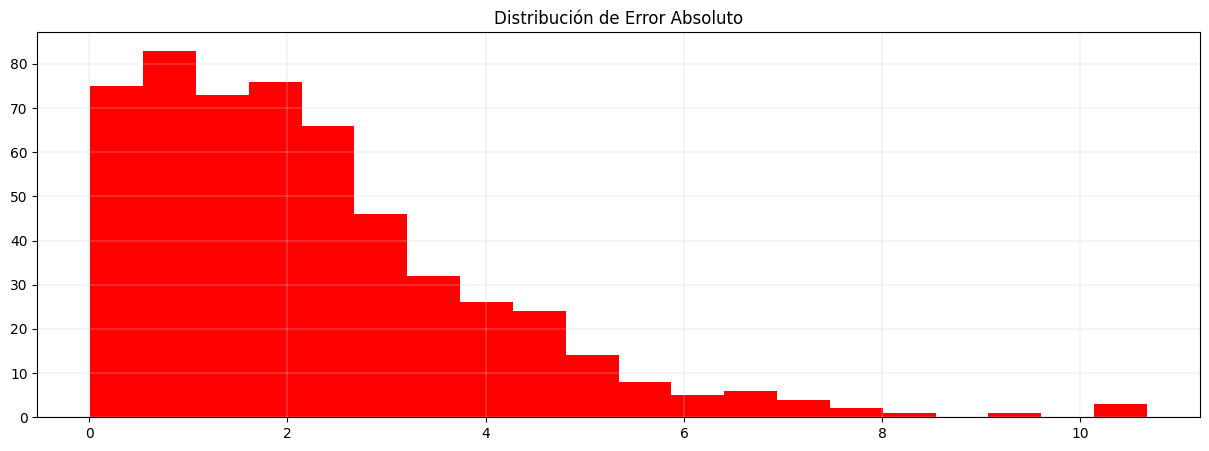


 Error Relativo: 
            Mínimo: 0.08% 
            Promedio: 15.72 ± 17.46
            Máximo: 154.65% 


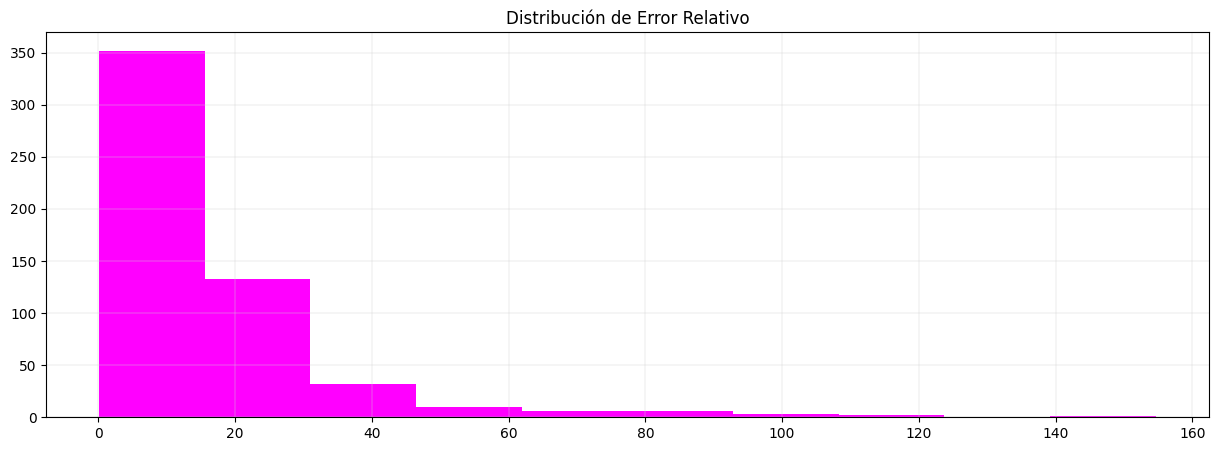

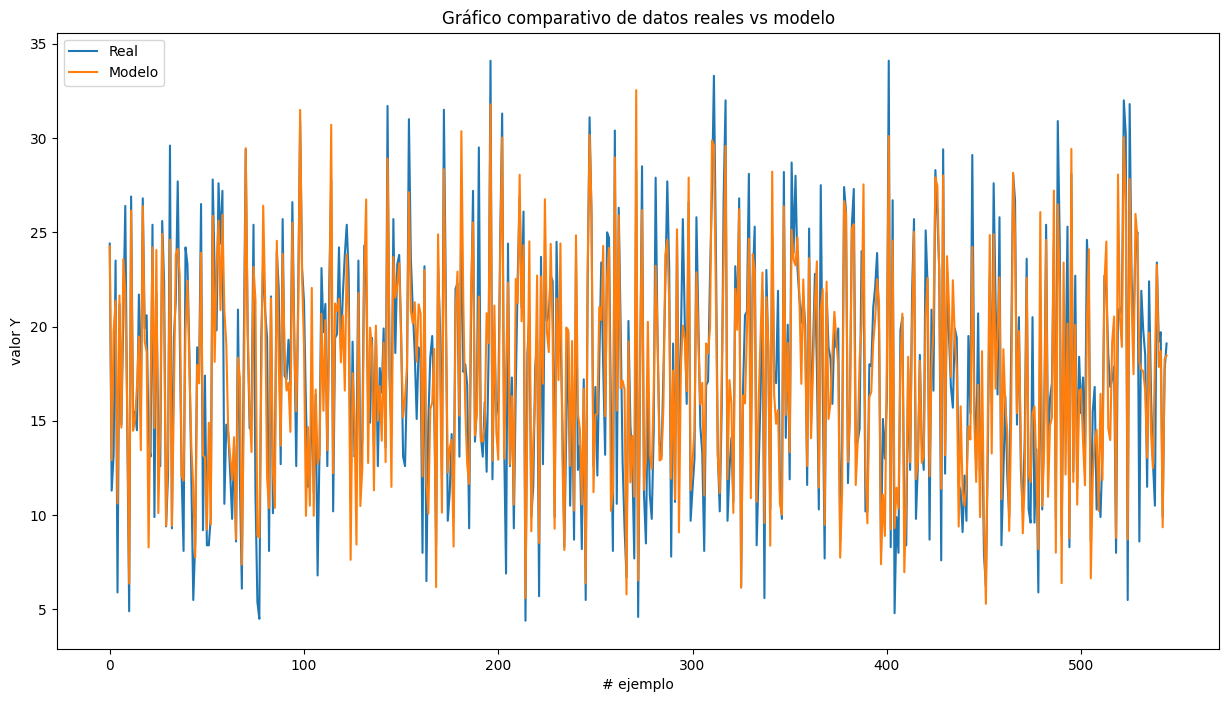

In [11]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}

tipo_output_softMax = False

# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")

    # muestra grafico
    graficarSerieDatos(datosReal=y,
                      datosModelo=estimVals,
                      titulo="Gráfico comparativo de datos reales vs modelo")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
 Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 R:  12.5000 / M:  15.3552 [   2.8552 |    22.84% ]
 R:  17.9000 / M:  19.9495 [   2.0495 |    11.45% ]
 R:  19.7000 / M:  21.0941 [   1.3941 |     7.08% ]
 R:  13.3000 / M:  11.8124 [   1.4876 |    11.19% ]
 R:   9.5000 / M:   9.5772 [   0.0772 |     0.81% ]
 R:  18.5000 / M:  15.1400 [   3.3600 |    18.16% ]
 R:   7.7000 / M:  10.4147 [   2.7147 |    35.26% ]
 R:  11.9000 / M:  15.2069 [   3.3069 |    27.79% ]
 R:  17.3000 / M:  18.5733 [   1.2733 |     7.36% ]
 R:   8.4000 / M:  10.3018 [   1.9018 |    22.64% ]
 R:  14.6000 / M:  14.0604 [   0.5396 |     3.70% ]
 R:  21.4000 / M:  18.9154 [   2.4846 |    11.61% ]
 R:  20.0000 / M:  18.7963 [   1.2037 |     6.02% ]
 R:  13.6000 / M:  11.8233 [   1.7767 |    13.06% ]
 R:  24.0000 / M:  22.6472 [   1.3528 |     5.64% ]
 R:  19.5000 / M:  17.0050 [   2.4950 |    12.80% ]
 R:  25.9000 / M:  23.8418 [   2.0582 |     7.95% ]
 R:  14.0000 /

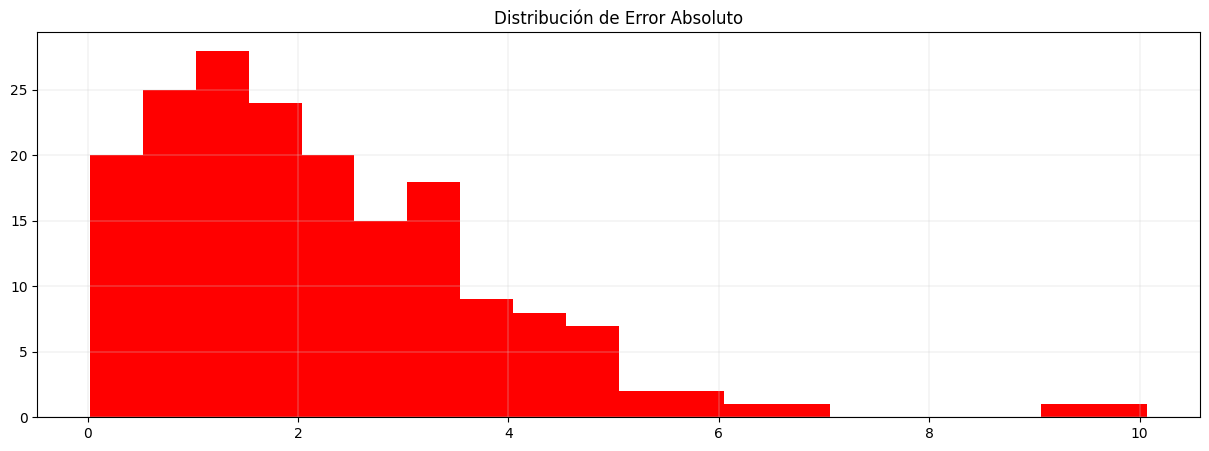


 Error Relativo: 
            Mínimo: 0.19% 
            Promedio: 14.53 ± 14.65
            Máximo: 98.73% 


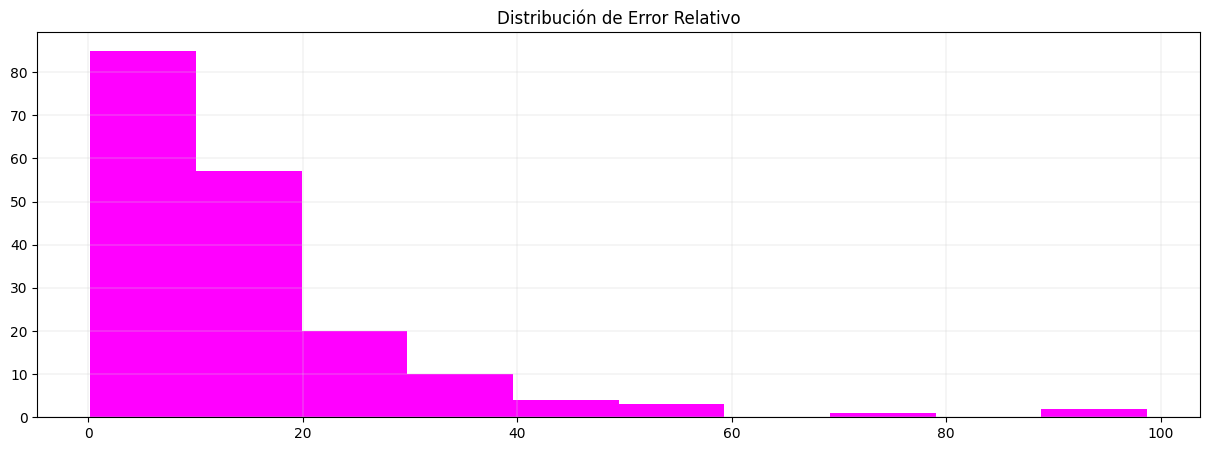

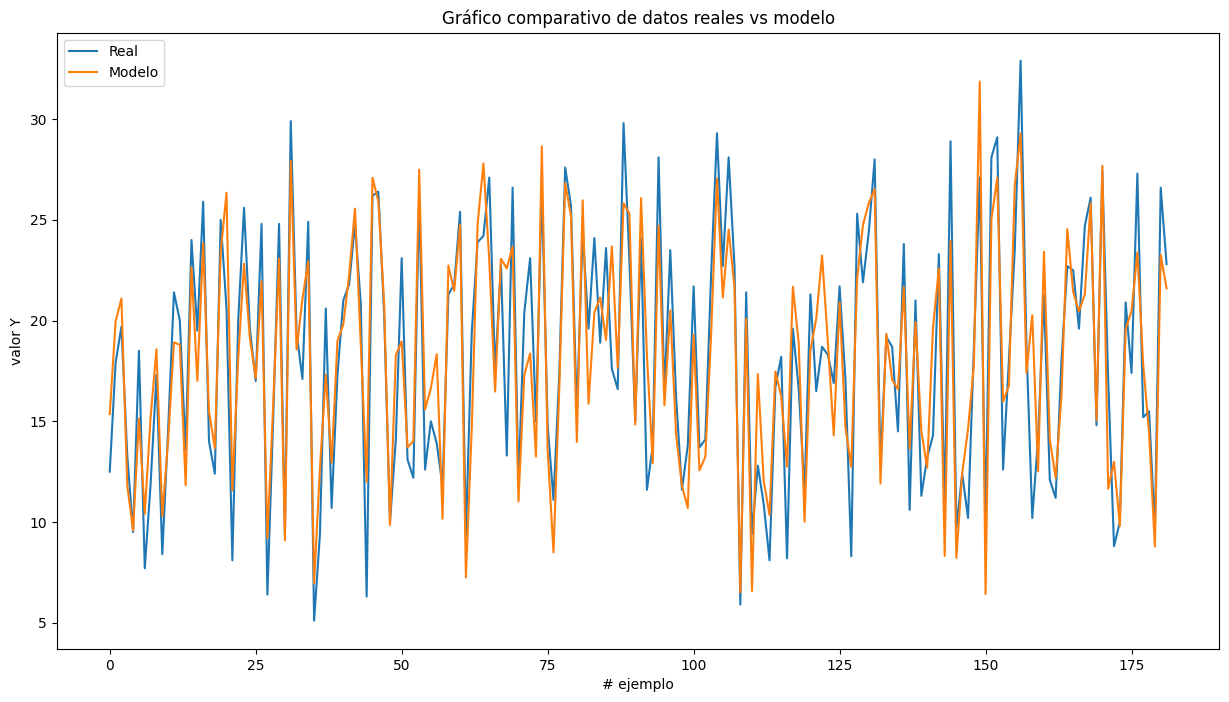

In [12]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [13]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosRC'  #@param {type:"string"}

if guardar_modelo:


    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/RC.joblib"
    joblib.dump(model, fn_modelo)
    print("\n-Modelo guardado en ", fn_modelo,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"

      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRC/RC.joblib 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRC/CLASES_MAP.txt 

